# A|B tests

## I. Выбор метрики и определение её существенности

"AAARRR" - Популярный подход к выбору метрик (важно определять не только метрики успеха, но и контрметрики)
   * A - Activity (Вовлечённость)
  *  A - Acquisition (Приобритение новых пользователей)
  *  A - Activation (Конверсия)
  *  R - Retention (Возвращаемость) 
  *  R - Referral (Рекомендации)
  *  R - Revenue (Выручка)

Возможно складывание метрик в Overall Evaluation Criterion **(OEC)**

## II. Определение размера выборки и её разбиение на части

Разбить выборку на части можно разными способами, однако важно, чтобы соблюдался критерий случайности. Также необходимо учитывать, чтобы в каждой подвыборке сохранялась пропорция кластеров, характерная для генеральной совокупности. В целом следует следить за тем, чтобы в группах A и B сравнивались схожие сущности. Например, сравнение двух коммерческих точек может быть нерелевантным из-за их различного расположения в городе: одна может находиться в промышленной зоне, а другая — на автозаправке. Чтобы повысить сопоставимость и точность формируемых групп, можно, например, использовать метод k-ближайших соседей.

In [8]:
# Пример Кода с разбиением выборки на 2 части с сохранением пропорций кластеров

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.DataFrame({
                    'id': range(16),
                    'cluster': ['A','A','A','A','A','A','A','A','A', 'B','B','B','C','C','C','C']
                  })

train, test = train_test_split(
                                df,
                                test_size=0.5,           # Разбиваем выборку пополам
                                stratify=df['cluster'],  # С сохранением пропоций кластеров
                                random_state=42
                               )

print(train['cluster'].value_counts())
print(test['cluster'].value_counts())

cluster
A    4
B    2
C    2
Name: count, dtype: int64
cluster
A    5
C    2
B    1
Name: count, dtype: int64




#### A. Для долей


$$n=\left( \frac{ \sqrt{p_{0}\times(1-p_{0})} \times Z_{1-\alpha}   + \sqrt{p_{\alpha}\times(1-p_{\alpha})} \times Z_{1-\beta}   }{p_{\alpha} - p_{0} }       \right)^2$$


$n$- число наблюдений

$\alpha$ - ошибка I рода (обычно 5%)

$\beta$ - ошибка II рода (обычно 80%)

$Z_{\alpha-1}$, $Z_{\beta-1}$ - квантили нормального распределения



ВАЖНО: Для того, чтобы найти размер выборки используя библиотеку `statsmodels` нам нужно привести желаеммый $EffectSize$ в стандартизированный вид (отнормированный на станадртное отклонение)



$$ effect = \frac{p_{0}-p_{\alpha}} {se}$$

При этом **для долей** стандартаная ошибка считается как
$$se=\sqrt{\frac{(n_{1}-1)*s_{1}^2 + (n_{2}-1)*s_{2}^2}{n_{1}+n_{2}-2}}$$

In [13]:
n_0, n_a = 468, 468
p_0, p_a = 0.1, 0.15

# дисперсии
var_0, var_a = p_0 * (1-p_0), p_a * (1-p_a)

# стандартизированный размер эффекта
effect_size = (p_a - p_0) / ((n_0 * np.sqrt(var_0)+ n_a * np.sqrt(var_a)) / (n_0+n_a))
print(f"Стандартизированный размер эффекта равен {round(effect_size,3)}")

Стандартизированный размер эффекта равен 0.152


In [18]:
from statsmodels.stats.power import zt_ind_solve_power

alpha = 0.05
beta = 0.05

sample_size = zt_ind_solve_power( 
                                 effect_size =  effect_size, # Стандартизированный размер эффекта
                                 nobs1 =None,                # Число наблюдейний мы не значем и Хотим вычислить
                                 alpha = alpha,
                                 power =(1- beta),
                                 ratio = 1,                 # Перекос в выборках, 1 - одинакового размера n_0/n_a
                                 alternative = 'larger'
                                 )
    
print(sample_size/2) # так как у нас 2 выбоки

467.2396197591212



#### Б. Для средних

#### Формула для двух независимых групп:

$$
n = \frac{ \left( Z_{1-\alpha/2} + Z_{1-\beta} \right)^2 \cdot (\sigma_0^2 + \sigma_\alpha^2) }{ (\mu_\alpha - \mu_0)^2 }
$$

Где:  
- $n$ — размер выборки в каждой группе  
- $\sigma_0^2, \sigma_\alpha^2$ — дисперсии в исходной и альтернативной группах
- $ \mu_{0}, \mu_ \alpha$  — средние в нулевой и альтернативной гипотезах
- $Z_{1-\alpha/2}$ — квантиль нормального распределения для двустороннего теста  
- $Z_{1-\beta}$ — квантиль нормального распределения, связанный с мощностью теста $(1-\beta)  $


Класс `TtestIndPower` предназначен для анализа мощности для t-теста Стюдента с независимыми выборками (`TtestPower` lдля обычного либо с зависимыми выборками)Ю

У каждого объекта этого класса есть метод `solve_power`. Он может использоваться, чтобы найти любой из параметров: мощность, число наблюдений, эффект, уровень значимости. Три известные части информации подставляются в функцию. Вместо неизвестной ставится `None`.

Снова в качестве эффекта на вход идёт стандартизированный эффект:

$$
effect = \frac{\bar{x_1} - \bar{x_2}}{se}
$$



$$
se = \sqrt{ \frac{s_{1}^2+s_{2}^2 }{2}}
$$

In [52]:

# Example data
mean1 = 100
mean2 = 102
sd1 = 10
sd2 = 12

# Compute standardized effect size (Cohen's d)
s_pooled = np.sqrt((sd1**2 + sd2**2) / 2)
effect_size = (mean1 - mean2) / s_pooled

print("Manually calculated Effect size (Cohen's d):", effect_size)

def standardize_effect(mean1, mean2, sd1, sd2, reverse=False, effect_size=None):
    s_pooled = np.sqrt((sd1**2 + sd2**2) / 2)
    
    if reverse:
        if effect_size is None:
            raise ValueError("effect_size must be provided when reverse=True")
        # To get mean difference from Cohen's d
        return effect_size * s_pooled
    else:
        return np.abs((mean1 - mean2) / s_pooled)

print(F"Effect size from function {standardize_effect(mean1,mean2,sd1,sd2)}")

Manually calculated Effect size (Cohen's d): -0.18107149208503706
Effect size from function 0.18107149208503706


In [31]:
from statsmodels.stats.power import TTestIndPower

effect = effect_size                  # стандартизированный, + или - (не важно)
alpha = 0.05
power = 0.95                          # (1-beta)

analysis = TTestIndPower()
analysis.solve_power(effect,
                     power=power,
                     nobs1=None,      # устанавливаем None именно тот параметр, котоый хотим вычислить
                     alpha=alpha, 
                     ratio=1)

793.6389199316625

In [602]:
effect = -0.6136                      # стандартизированный, + или - (не важно)
alpha = 0.05
power = 0.95                          # beta

analysis = TTestIndPower()
analysis.solve_power(None,            # устанавливаем None именно тот параметр, котоый хотим вычислить
                     power  = power,    
                     nobs1  = 793.638919931662500,      
                     alpha  = alpha, 
                     ratio  = 1)

0.18107147226859938

In [54]:
standardize_effect(mean1,mean2,sd1,sd2,reverse = True, effect_size = 0.18107147226859938) # Дестандартизируем эффект

1.9999997811202919

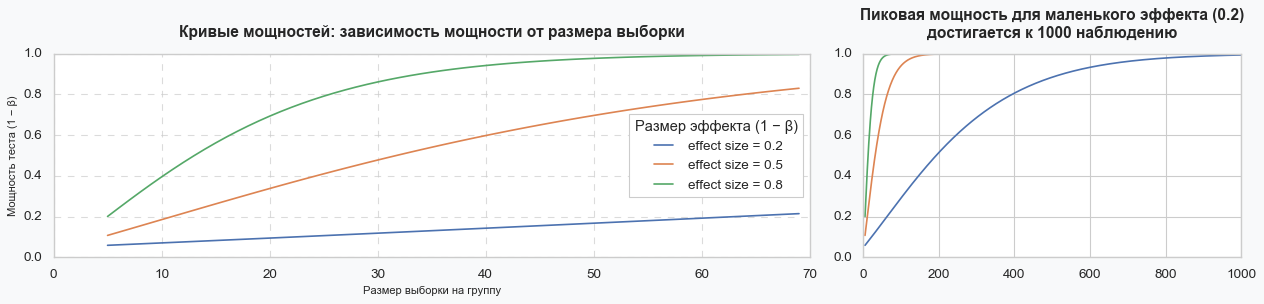

In [618]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower

# Parameters
effect_sizes = [0.2, 0.5, 0.8]  # small, medium, large
sample_sizes = np.arange(5, 70)
alpha = 0.05

analysis = TTestIndPower()

# Plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 4) , gridspec_kw={'width_ratios': [2, 1]})

for es in effect_sizes:
    power = analysis.power(effect_size=es, nobs1=sample_sizes, alpha=alpha)
    ax1.plot(sample_sizes, power, label=f"effect size = {es}")


ax1.set_title("Кривые мощностей: зависимость мощности от размера выборки", fontsize=14, weight='bold', pad=15)
ax1.set_xlabel("Размер выборки на группу", fontsize=10)
ax1.set_ylabel("Мощность теста (1 − β)", fontsize=10)
ax1.legend(title="Размер эффекта (1 − β)",loc='center right')
ax1.grid(True, linestyle='--', alpha=0.7)



for es in effect_sizes:
    power = analysis.power(effect_size=es, nobs1=np.arange(5, 1000), alpha=alpha)
    ax2.plot(np.arange(5, 1000), power, label=f"effect size = {es}")
ax2.set_title("Пиковая мощность для маленького эффекта (0.2)\nдостигается к 1000 наблюдению", fontsize=14, weight='bold', pad=15)


fig.patch.set_facecolor('#f8f9fa')
plt.tight_layout()
plt.show()

Чем выше мощность теста тем больше нужно наблюдений и чем меньший мы хотим уловить размер эффекта, тем больше наблюдений нам нужно

**Стоит учесть:**

* репрезентативность выборки *(проблема самоотбора в онлайн исследованиях, большие кластеры людей важных для исследования могут просто не перейти по ссылке, например занятые бизнесмены)*
* скрытые перемнные *(например, при оценке выхода урожая, с использование опрделенных удобреней нельзя просто разделить поле на 2 части, и использовать на этих частях разные типы удобрений, мы можем не учесть скрытые от нас факторы вроде геотермальных процессов под участками)*
* не стоит подглядывать и прерывать исследования до его завершения или продлевать после, не стоит также менят метрики во время исследования (однако не так критично для бандитсяких алгоритмов)
* стоит делать поправку на эффект новизны *(нововедения может нравится только потому что оно новое)*
* следует очищать данные от шумов *(сезонность)* и выбросов. Также можно обратить внимание на методы уменьшения дисперсии в метриках e.g. [CUPED](https://towardsdatascience.com/how-to-double-a-b-testing-speed-with-cuped-f80460825a90/)
* перед началом исследования проводим **AA тесты**, где оба вариант контрольные, чтобы минимизировать возможность получения ошибок I. рода., посмотреть, что дизайн нашего теста не приводит к ложноположительным результатам
* тестирование проводим в условиях максимально приближенных к естественным для данного процесса

In [57]:
# Ошибка I рода отвергнута верная 0 гиппотеза, неверная 0 гиппотеза принята!

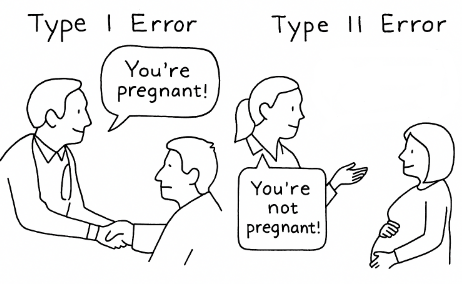

## III. Выбор статистической модели сравнения гиппотез

| Outcome →  Conditions ↓ | Независимые выборки n (≥ 30) | Независимые n (< 30) | Зависимые (парные) | Байесовский метод |
|---------------------------|---------------------------:|----------------------------:|------------------:|--------------------:|
| **Mean differen**         |    T-test or Welch’s t-test (robust to unequal variances) | Welch’s t-test or permutation / bootstrap on mean | Paired t-test / Wilcoxon signed-rank | Bayesian t-test (Rouder et al.) or normal–normal model |
| **Median / ordinal**      | Mann–Whitney U / bootstrap CI for median | Mann–Whitney U / permutation | Wilcoxon signed-rank / permutation | Bayesian rank-based or robust hierarchical model |
| **Proportion (binary)** | Two-proportion z-test / χ² | Fisher’s exact (if small counts) | McNemar test (paired) | Bayesian proportion test (Beta–Binomial model) |
| **>2 groups (means)** | One-way ANOVA or Welch ANOVA | Kruskal–Wallis / permutation ANOVA | Repeated-measures ANOVA / Friedman | Bayesian ANOVA or hierarchical model |
| **Variance equality** | Levene’s test (robust) | Levene’s or Brown–Forsythe | — | Bayesian model comparison on variance ratio |
| **Normality check** | Shapiro–Wilk (n < 5000) / D’Agostino–Pearson | Shapiro–Wilk / visual (Q–Q plot) | — | Posterior predictive check of residuals |
| **Multiple-test corrections** | Holm–Bonferroni (FWER) / Benjamini–Hochberg (FDR) | Holm–Bonferroni / BH / BY (if dependent) | Holm–Bonferroni / permutation-based FWER | Bayesian FDR (Storey, 2003) or posterior probability thresholding |olding |

<h3 style="color: navy;">Кейc I - Cмертность в швейцарских кантонах</h3> 
<h4 style="color: navy;">Подготовка данных</h4> 

Предположим, что нам необходимо сравнить средние значения уровня детской смертности в кантонах Швейцарии, где преобладает католическое население и где преобладает протестантское население. Сформируем две выборки на основе имеющихся данных: выберем соответствующие строки в таблице и возьмем столбец `Infant.Mortality.`

In [201]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [202]:
plt.style.available
sns.set_theme(style="whitegrid", font_scale=1.1)

In [203]:
df = pd.read_csv('https://raw.githubusercontent.com/V23KTOR/Study/refs/heads/main/Statistics/data/swiss.csv')
df.head()

,Unnamed: 0,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
0,Courtelary,80.2,17.0,15,12,9.96,22.2
1,Delemont,83.1,45.1,6,9,84.84,22.2
2,Franches-Mnt,92.5,39.7,5,5,93.40,20.2
3,Moutier,85.8,36.5,12,7,33.77,20.3
4,Neuveville,76.9,43.5,17,15,5.16,20.6


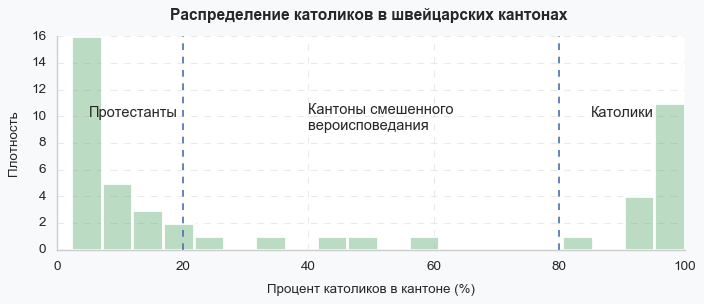

In [324]:
fig, ax = plt.subplots(figsize=(9, 4))

sns.histplot( 
                data=df,
                x='Catholic',
                color='#55A868',
                alpha=0.4,
                linewidth=2.5,
                bins = 20
              )

ax.set_xlabel('Процент католиков в кантоне (%)', fontsize=12, labelpad=10)
ax.set_ylabel('Плотность', fontsize=12, labelpad=10)
ax.set_title( 'Распределение католиков в швейцарских кантонах ', fontsize=14, weight='bold', pad=15)


ax.axvline(x=20, ymin=0, ymax=16,linestyle='--')
ax.axvline(x=80, ymin=0, ymax=16,linestyle='--')

plt.annotate("Протестанты",(5,10))
plt.annotate("Католики",(85,10))
plt.annotate("Кантоны смешенного \nвероисповедания",(40,9))

sns.despine()
ax.grid(True, linestyle='--', alpha=0.4)
fig.patch.set_facecolor('#f8f9fa')
plt.tight_layout()
plt.show()

In [240]:
def Is_catholic(x):
    if x >= 90:
        return "Католики"
    if x <=20:
        return "Протестанты"
    else:
        return "Смешенного вероисповедания"

In [241]:
df["Main Religion"]=df.Catholic.apply(Is_catholic)

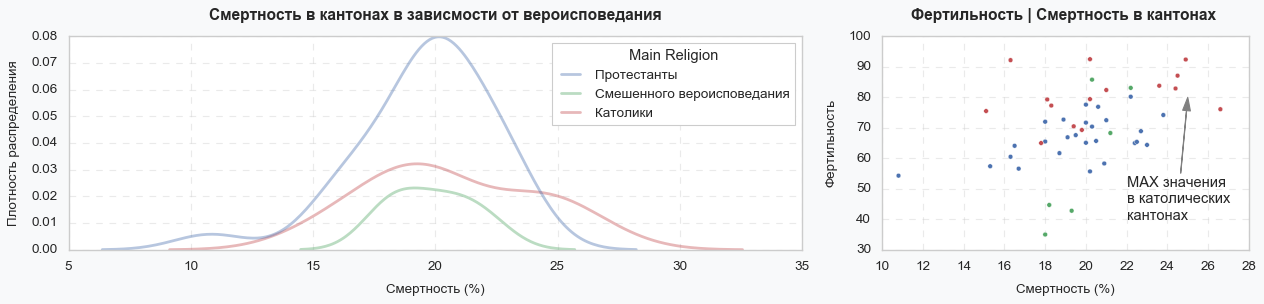

In [322]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 4) , gridspec_kw={'width_ratios': [2, 1]})

# Левый график
sns.kdeplot(ax = ax1,
            data=df,
            x='Infant.Mortality',
            hue='Main Religion',
            palette=['#4C72B0', '#55A868', '#C44E52'],
            alpha=0.4,
            linewidth=2.5,
            )

ax1.set_xlabel('Смертность (%)', fontsize=12, labelpad=10)
ax1.set_ylabel('Плотность распределения', fontsize=12, labelpad=10)
ax1.set_title('Смертность в кантонах в зависмости от вероисповедания', fontsize=14, weight='bold', pad=15)
ax1.grid(True, linestyle='--', alpha=0.4)


# Правый график
sns.scatterplot(data = df, 
                x = 'Infant.Mortality', 
                y = 'Fertility', 
                size=10000,
                hue = 'Main Religion', 
                palette=['#4C72B0', '#55A868', '#C44E52'], 
                legend= False
                )

ax2.annotate("MAX значения\nв католических \nкантонах",(25,80), (22,40),arrowprops={'color':'grey','width':0.2,"headwidth" : 7})
ax2.set_xlabel('Смертность (%)', fontsize=12, labelpad=10)
ax2.set_ylabel('Фертильность', fontsize=12, labelpad=10)
ax2.set_title('Фертильность | Смертность в кантонах ', fontsize=14, weight='bold', pad=15)
ax2.grid(True, linestyle='--', alpha=0.4)

fig.patch.set_facecolor('#f8f9fa')
plt.tight_layout()
plt.show()

In [327]:
# Разобъм данные на 2 выборки в зависимости от вероисповедания в кантонах
sample_C = df[df['Main Religion'] == 'Католики']['Infant.Mortality']
sample_NC = df[df['Main Religion'] == 'Протестанты']['Infant.Mortality']

<h4 style="color: navy;"> T-test (критерий Стьюдента для двух выборок) </h4>

T-test используется для сравнения средних значений двух генеральных совокупностей в предположении, что обе выборки взяты из нормального распределения. Существует две разновидности t-теста:


1.  t-тест для связных (парных) выборок. В связных выборках объекты связаны друг с другом. Пример связных выборок: значения уровня смертности в одних и тех же кантонах до и после какой-нибудь реформы
2. t-тест для независимых выборок )                  *   *Нулевая гипотеза: дисперсии двух генеральных совокупностей равны, то есть $H{_0}:\alpha{_1}=\alpha{_2}$*
             
          *    *Альтернативная гипотеза: дисперсии двух генеральных совокупностей не равны, то есть $H{_0}:\alpha{_1} \neq \alpha{_2}$*

В stats в t-тесте в качестве альтернативной гипотезы используется двусторонняя альтернатива (средние не равны) и всегда выводится соответствующее p-value (two-tailed). То же будет характерно для всех последующих тестов. Так как наши выборки независимы, нам нужна функция ttest_ind(), от independent

In [336]:
# Equal variance independent T-Test
stats.ttest_ind(sample_C, sample_NC, alternative = 'two-sided')

TtestResult(statistic=1.15671613550964, pvalue=0.25442462571959057, df=39.0)

**alternative**{`two-sided`, `less`, `greater`}, optional
Defines the alternative hypothesis. The following options are available (default is ‘two-sided’):

`two-sided`: the means of the distributions underlying the samples are unequal.

`less`: the mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample.

`greater`: the mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample.

<h4 style="color: navy;">Тест Левена на равенство дисперсий $\sigma^2$</h4>

Мы помним, что диспресия в наших выборках отличается, следует провести `тест Левена` на равенство дисперсий.

* *Нулевая гипотеза: дисперсии двух генеральных совокупностей равны, то есть  $H{_0}:\sigma{_1}^2=\sigma{_2}^2$*
* *Альтернативная гипотеза: дисперсии двух генеральных совокупностей не равны, то есть  $H{_1}:\sigma{_1}^2\neq\sigma{_2}^2$*

In [337]:
stats.levene(sample_C, sample_NC)

LeveneResult(statistic=1.0858226958040642, pvalue=0.3038153373982655)

<h4 style="color: navy;">$\sigma{_1}^2\neq\sigma{_2}^2$----> Welch's T-Test </h4>

По результатам теста мы видим, что дисперсии не равны, соотвественно, мы должны прибегнукть к `Welch's T-Test`

In [338]:
stats.ttest_ind(sample_C, sample_NC, alternative = 'two-sided', equal_var = False)

TtestResult(statistic=1.0984107874428166, pvalue=0.2824720036728524, df=25.047398354662228)

<h4 style="color: navy;">Проверка на нормальность распределения</h4> 

Мы провели T-test для нормально распределения, теперь же, смотрим `Если мы не можем считать распределение генеральных совокупностей, откуда взяты выборки`, нормальным, то следует использовать методы, основанные не на самих наблюдениях в выборках, а на их рангах. Для сравнения распределений (иногда речь идет о сравнении медиан) используются тесты Уилкоксона и Манна-Уитни. Начнем с теста Уилкоксона (не проверяем, является ли распределение данных нормальным, просто для примера используем те же выборки).

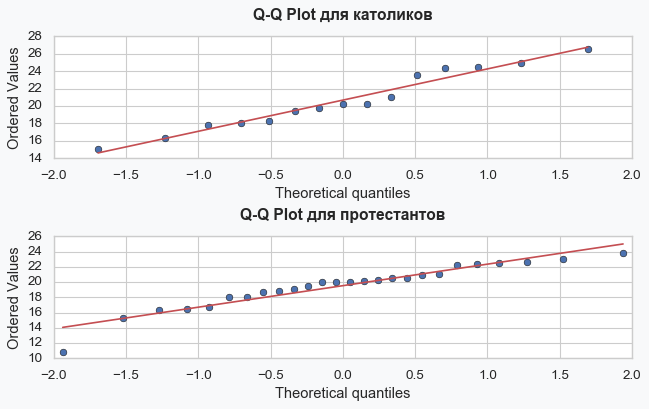

In [344]:
fig,axes=plt.subplots(2,1,figsize=(8, 5),constrained_layout=True)

stats.probplot(sample_C, dist="norm", plot=axes[0])
stats.probplot(sample_NC, dist="norm", plot=axes[1])

axes[0].set_title('Q-Q Plot для католиков', fontsize=14, weight='bold', pad=15)
axes[1].set_title('Q-Q Plot для протестантов', fontsize=14, weight='bold', pad=15)

fig.patch.set_facecolor('#f8f9fa')
plt.show()

ПО Q-Q графику можно сказать что распределение смертности в группе католиков является скошенным, для протестантов распределение похоже имеет толстые хвосты *(слабовыраженные)*, тем не  менее стоит прибегнуть к дополнительным тестам чтобы с большей уверенностью отвергнуть нормальность распределений!

In [350]:
from scipy.stats import shapiro
stat, p_value = shapiro(sample_C)

print(f"Shapiro-Wilk test: (рекомендуется для n < 50) statistic")
print("-"*50)
print(f"Для католиклов statistic={stat:.4f}, p-value={p_value:.4f}")

stat, p_value = shapiro(sample_NC)
print(f"Для протестантов statistic={stat:.4f}, p-value={p_value:.4f}")

Shapiro-Wilk test: (рекомендуется для n < 50) statistic
--------------------------------------------------
Для католиклов statistic=0.9538, p-value=0.5861
Для протестантов statistic=0.9248, p-value=0.0584


In [351]:
from scipy.stats import normaltest

print(f"Тест Д'Агостино: (хорош для n > 50)")
print("-"*50)
stat, p_value = normaltest(sample_C)
print(f"D'Agostino test: statistic={stat:.4f}, p-value={p_value:.4f}")

stat, p_value = normaltest(sample_NC)
print(f"D'Agostino test: statistic={stat:.4f}, p-value={p_value:.4f}")

Тест Д'Агостино: (хорош для n > 50)
--------------------------------------------------
D'Agostino test: statistic=1.0200, p-value=0.6005
D'Agostino test: statistic=9.8891, p-value=0.0071


In [361]:
from scipy.stats import anderson

print('Тест Андерсона-Дарлинга - это статистический тест для проверки нормальности распределения,\nкоторый особенно чувствителен к отклонениям в хвостах распределения')
print('\nH0 = данные распределены нормальным образом')
print("-"*50,'\n')

print("Для католиков!")
result = anderson(sample_C, dist='norm')
print(f"Anderson-Darling test: statistic={result.statistic:.4f}")

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f"На уровне значимости {sl}%: нормальное (stat < {cv})")
    else:
        print(f"На уровне значимости {sl}%: не нормальное (stat >= {cv})")

print("\n")

print("Для протестантов!")
result = anderson(sample_NC, dist='norm')
print(f"Anderson-Darling test: statistic={result.statistic:.4f}")

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f"На уровне значимости {sl}%: нормальное (stat < {cv})")
    else:
        print(f"На уровне значимости {sl}%: не нормальное (stat >= {cv})")

Тест Андерсона-Дарлинга - это статистический тест для проверки нормальности распределения,
который особенно чувствителен к отклонениям в хвостах распределения

H0 = данные распределены нормальным образом
-------------------------------------------------- 

Для католиков!
Anderson-Darling test: statistic=0.3417
На уровне значимости 15.0%: нормальное (stat < 0.498)
На уровне значимости 10.0%: нормальное (stat < 0.568)
На уровне значимости 5.0%: нормальное (stat < 0.681)
На уровне значимости 2.5%: нормальное (stat < 0.794)
На уровне значимости 1.0%: нормальное (stat < 0.945)


Для протестантов!
Anderson-Darling test: statistic=0.5262
На уровне значимости 15.0%: не нормальное (stat >= 0.516)
На уровне значимости 10.0%: нормальное (stat < 0.587)
На уровне значимости 5.0%: нормальное (stat < 0.705)
На уровне значимости 2.5%: нормальное (stat < 0.822)
На уровне значимости 1.0%: нормальное (stat < 0.978)


Похоже что данные всё же распределены нормально, однако посмотрим как справятся непараметрические методы с попхожей задачей, к которым мы бы точно прибегнули будь в нашем расположении распределения не относящиеся к нормальным!

<h4 style="color: navy;">Непараметрические методы (сравнение медиан)</h4> 
<h4 style="color: navy;">Wilcoxon test & Mann-Whitney test</h4> 

Если мы не можем считать распределение генеральных совокупностей, откуда взяты выборки, нормальным, то следует использовать методы, основанные не на самих наблюдениях в выборках, а на их рангах. Для сравнения распределений (иногда речь идет о сравнении медиан) используются тесты Уилкоксона и Манна-Уитни. Начнем с теста **Mann-Whitney**.

Нулевая гипотеза: выборки взяты из одного и того же распределения, то есть $ H_{0}:F(x)=G(x)$
 
Альтернативная гипотеза: выборки взяты из разных распределений, то есть  $H_{1}:F(x)≠G(x)$

**Ограничения:** В каждой из выборок должно быть не менее 3 значений признака. Допускается, чтобы в одной выборке было два значения, но во второй тогда не менее пяти.
В выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10)

In [363]:
stats.mannwhitneyu(sample_C, sample_NC, alternative = 'two-sided')

MannwhitneyuResult(statistic=221.0, pvalue=0.48986147928821533)

**Wilcoxon test** для парных **(зависимых) выборок**, например: "до и после" лечения, измерения на тех же объектах.

Основная идея простых парных тестов, таких как тест Вилкоксона или парный t-тест, заключается в том, что вы измеряете одну и ту же «биологическую единицу» (т.е. объект) до и после вмешательства. Затем вы фактически смотрите на медиану (тест Вилкоксона) или среднее (парный t-тест) разницы между двумя измерениями и спрашиваете, отличается ли она от нуля.

Если у вас нет одинакового количества объектов до и после вмешательства, то почти по определению тест Вилкоксона здесь не подходит.

Единственное исключение — если вы не смогли измерить какие-то данные после или до вмешательства, но данные для другой группы у вас есть. В этом случае замените отсутствующие данные на "NA" (не доступно), и команда в R выполнится, игнорируя данные, для которых нет парных измерений.a.ах

<h3 style="color: navy;">Кейc II - Снижение давления у испытуемых</h3> 

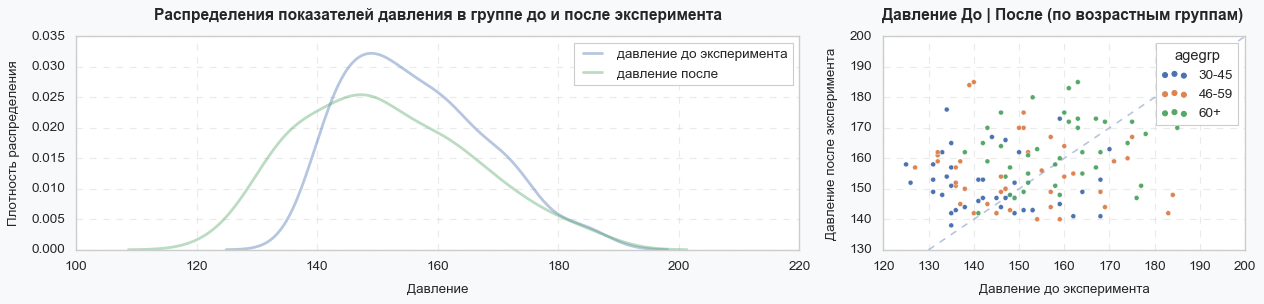

In [469]:
df2 = pd.read_csv("https://raw.githubusercontent.com/V23KTOR/Study/refs/heads/main/Statistics/data/blood_pressure.csv")
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 4) , gridspec_kw={'width_ratios': [2, 1]})

# Левый график
sns.kdeplot(ax = ax1,
            data=df2,
            x='bp_before',
            color='#4C72B0',
            alpha=0.4,
            linewidth=2.5,
            label="давление до эксперимента",
            legend=True
            )

sns.kdeplot(ax = ax1,
            data=df2,
            x='bp_after',
            color='#55A868',
            alpha=0.4, 
            linewidth=2.5,
            label="давление после",
            legend=True
            )

ax1.set_xlabel('Давление', fontsize=12, labelpad=10)
ax1.set_ylabel('Плотность распределения', fontsize=12, labelpad=10)
ax1.set_title('Распределения показателей давления в группе до и после эксперимента', fontsize=14, weight='bold', pad=15)
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend()

# Правый график
sns.scatterplot(data = df2, 
                x = 'bp_after', 
                y = 'bp_before', 
                hue = 'agegrp', 
                legend=True
                )


ax2.set_xlabel('Давление до эксперимента', fontsize=12, labelpad=10)
ax2.set_ylabel('Давление после эксперимента', fontsize=12, labelpad=10)
ax2.set_title('Давление До | После (по возрастным группам) ', fontsize=14, weight='bold', pad=15)
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.axline((190,190), slope=1,linestyle='--', alpha=0.4 )


fig.patch.set_facecolor('#f8f9fa')
plt.tight_layout()
plt.show()

In [424]:
stats.levene(df2.bp_before, df2.bp_after)
# Дисперсии равны

LeveneResult(statistic=4.863729003161597, pvalue=0.028383666362348802)

In [426]:
# А вот распределение на нормально не похоже
print("До эксперимента!")
result = anderson(df2.bp_before, dist='norm')
print(f"Anderson-Darling test: statistic={result.statistic:.4f}")

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f"На уровне значимости {sl}%: нормальное (stat < {cv})")
    else:
        print(f"На уровне значимости {sl}%: не нормальное (stat >= {cv})")

print("\n")

print("После эксперимента!")
result = anderson(df2.bp_after, dist='norm')
print(f"Anderson-Darling test: statistic={result.statistic:.4f}")

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f"На уровне значимости {sl}%: нормальное (stat < {cv})")
    else:
        print(f"На уровне значимости {sl}%: не нормальное (stat >= {cv})")

До эксперимента!
Anderson-Darling test: statistic=1.4009
На уровне значимости 15.0%: не нормальное (stat >= 0.558)
На уровне значимости 10.0%: не нормальное (stat >= 0.636)
На уровне значимости 5.0%: не нормальное (stat >= 0.763)
На уровне значимости 2.5%: не нормальное (stat >= 0.89)
На уровне значимости 1.0%: не нормальное (stat >= 1.059)


После эксперимента!
Anderson-Darling test: statistic=0.7583
На уровне значимости 15.0%: не нормальное (stat >= 0.558)
На уровне значимости 10.0%: не нормальное (stat >= 0.636)
На уровне значимости 5.0%: нормальное (stat < 0.763)
На уровне значимости 2.5%: нормальное (stat < 0.89)
На уровне значимости 1.0%: нормальное (stat < 1.059)


**Проведём Wilcoxon test** 

$H_{0}$: Давления в обеих группах не отличаются

$H_{1}:$ Эксперимент привёл к снижению давления в испытуемой группе

In [441]:
test=stats.wilcoxon(df2.bp_after, df2.bp_before, alternative = 'less',nan_policy='omit') 
test

WilcoxonResult(statistic=2234.5, pvalue=0.0007053666782721429)

In [ ]:
# Примерные данные
before <- c(120, 130, 128, 125, 132, 127)
after  <- c(118, 126, 125, 123, 130, 124)

# Тест Вилкоксона
test <- wilcox.test(after, before, paired = TRUE, alternative = "less")

# Посмотрим результат
test

# Расчёт размера эффекта r
# Извлекаем Z-значение вручную
z <- qnorm(test$p.value / 2) * sign(test$statistic - (length(before)*(length(before)+1)/4))
r <- abs(z) / sqrt(length(before))

r


In [439]:
df2.bp_before.mean() - df2.bp_after.mean()

5.091666666666669

<h3 style="color: navy;">Кейc III - Множественное тестирование и корм для цыплят</h3> 

**ANOVA**

In [446]:
df3=pd.read_csv('https://raw.githubusercontent.com/V23KTOR/Study/refs/heads/main/Statistics/data/chickwts.csv')

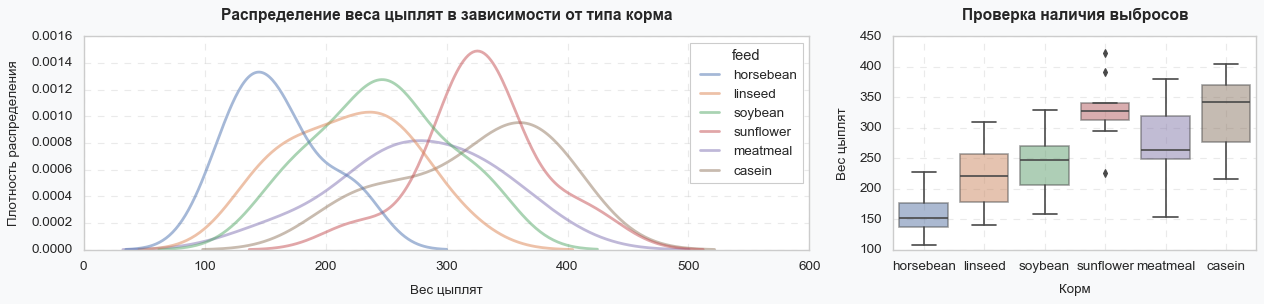

In [494]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 4) , gridspec_kw={'width_ratios': [2, 1]})

# Левый график
sns.kdeplot(ax = ax1,
            data=df3,
            x='weight',
            hue='feed',
            alpha=0.5,
            linewidth=2.5,
            legend=True
            )

ax1.set_xlabel('Вес цыплят', fontsize=12, labelpad=10)
ax1.set_ylabel('Плотность распределения', fontsize=12, labelpad=10)
ax1.set_title('Распределение веса цыплят в зависимости от типа корма', fontsize=14, weight='bold', pad=15)
ax1.grid(True, linestyle='--', alpha=0.4)


# Правый график
sns.boxplot(data = df3, 
                x = 'feed', 
                y = 'weight', 
                boxprops=dict(alpha=0.5)
                )


ax2.set_xlabel('Корм', fontsize=12, labelpad=10)
ax2.set_ylabel('Вес цыплят', fontsize=12, labelpad=10)
ax2.set_title('Проверка наличия выбросов', fontsize=14, weight='bold', pad=15)
ax2.grid(True, linestyle='--', alpha=0.4)



fig.patch.set_facecolor('#f8f9fa')
plt.tight_layout()
plt.show()

In [471]:
wgt = {}
for name, d in df3.groupby('feed'):
    wgt[name] = d.weight

In [496]:
stats.f_oneway(wgt['casein'], wgt['horsebean'], wgt['linseed'], wgt['meatmeal'], wgt['soybean'], wgt['sunflower'])

F_onewayResult(statistic=15.364799774712534, pvalue=5.936419853471304e-10)

Функция возвращает наблюдаемое значение F-статистики и p-value. В данном случае p-value близко к 0, поэтому гипотезу о равенстве средних генеральных совокупностей по группам можно отвергнуть на 1% уровне значимости. Средний вес цыплят, которых кормили разным кормом, отличается (ещё бы, horsebean или sunflower!).
Хотя из графиков выше мы помним, что sunflower содержит значительные выбросы, однако даже если исключить не данный тип корма из перечня, всё равно мы придём к статистически значимому результату и отвергнем нулевую гиппотезу о отсутсвии разницы между весом цыплят в группах с разными диетами.

In [497]:
stats.f_oneway(wgt['casein'], wgt['horsebean'], wgt['linseed'], wgt['meatmeal'], wgt['soybean'])

F_onewayResult(statistic=13.165478824546538, pvalue=1.4950094272149452e-07)

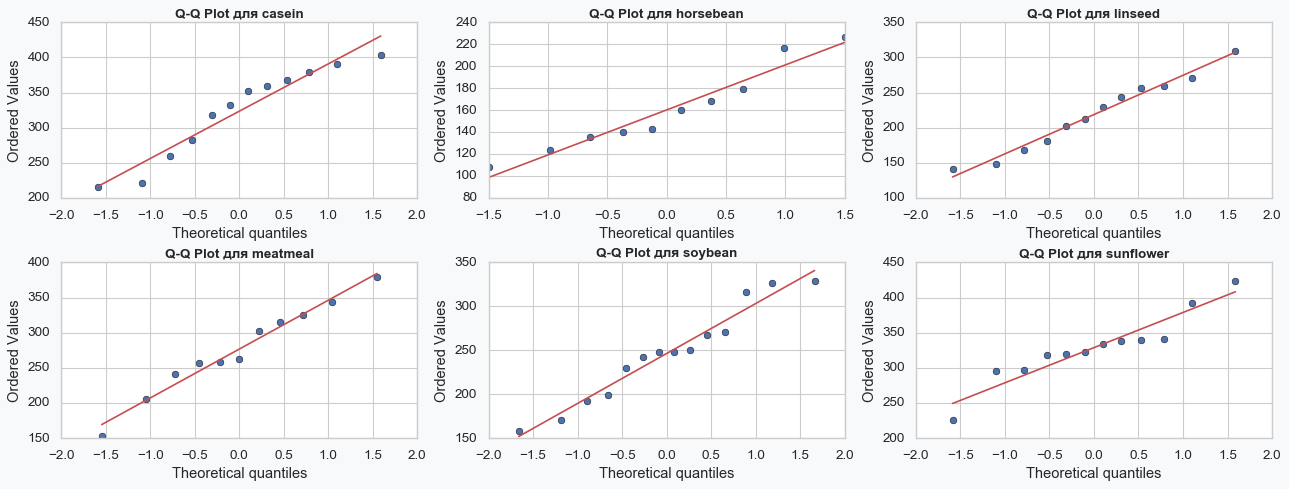

In [498]:
n = len(wgt.keys())
rows, cols = 2, int(n/2 + n%2)

fig, axes = plt.subplots(rows, cols, figsize=(16, 6), constrained_layout=True)
axes = axes.flatten()  # делаем одномерным для удобства

for i, key in enumerate(wgt.keys()):
    stats.probplot(wgt[key], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot для {key}', fontsize=12, weight='bold')

fig.patch.set_facecolor('#f8f9fa')
plt.show()

Q-Q графики показывают нам, что распределения не нормальыне, поэтому, перейдём к непараметрическим методам множественного тестирования


**Kruskal-Wallis test**

Критерий Краскела-Уоллиса используется, когда нам необходимо сравнить распределения более, чем в двух группах в предположении, что выборки взяты не из нормального распределения (распределения неизвестны).

Нулевая гипотеза: выборки взяты из одного и того же распределения, то есть:$ _{ }H0:F(x)=G(x)=⋯=H($x)
 

Альтернативная гипотеза: выборки взяты из разных распределений.


In [490]:
stats.kruskal(wgt['casein'], wgt['horsebean'], wgt['linseed'], wgt['meatmeal'], wgt['soybean'], wgt['sunflower'])

KruskalResult(statistic=37.34271769425624, pvalue=5.112829511937094e-07)

Когда ANOVA или Kruskal показал, что различия есть,
нужно выяснить — между какими группами они существуют.

Для этого применяют пост-хок (post-hoc) тесты — т.е. множественные попарные сравнения:

$\mu_1$ *VS.* $\mu_2$

$\mu_1$ *VS.* $\mu_3$

$\mu_1$ *VS.* $\mu_n$

....

Каждое такое сравнение — отдельный статистический тест.
Но если просто провести много тестов, возрастает риск ложноположительных результатов (ошибка I рода).
Вот тут и вступают в игру методы множественной коррекции.

<h3 style="color: navy;">Кейc IV - Завод A и его процент брака</h3> 

Сценарий: на четырёх заводах (A, B, C, D) производят одинаковую деталь. Проверяем, одинаково ли число бракованных деталей во всех заводах, или на заводе A доля брака больше.


$H0: P_A = P_B = P_C = P_D$ (доли брака одинаковы)

$H1: P_A > P_B$ or $P_A > P_C $ or $P_A > P_D$

Проверим все гиппотезы без коррекции на множественное тестирование, потом ввёдем её

In [523]:
n_A = 700  #  Кол-во деталей выпущено
m_A = 35 #  Кол-во брака

n_B = 380
m_B = 7

n_C = 410
m_C = 12

n_D = 1050
m_D = 41

alpha = 0.05

In [547]:
print(f"Сводка по браку на заводах")
print(f"-"*30)
print(f"Процент брака на заводе A - {round(m_A/n_A*100,2)}%")
print(f"Процент брака на заводе B - {round(m_B/n_B*100,2)}%")
print(f"Процент брака на заводе C - {round(m_C/n_C*100,2)}%")
print(f"Процент брака на заводе D - {round(m_D/n_D*100,2)}%") # доли для каждого дома

Сводка по браку на заводах
------------------------------
Процент брака на заводе A - 5.0%
Процент брака на заводе B - 1.84%
Процент брака на заводе C - 2.93%
Процент брака на заводе D - 3.9%


In [525]:
from statsmodels.stats.proportion import proportions_ztest

_, p1 = proportions_ztest((m_A,m_B),
                          (n_A,n_B),
                          value=0,
                          alternative = 'larger')

_, p2 = proportions_ztest((m_A,m_C),
                          (n_A,n_C),
                          value=0,
                          alternative = 'larger')

_, p3 = proportions_ztest((m_A,m_D),
                          (n_A,n_D),
                          value=0,
                          alternative = 'larger')

pval= np.array([p1,p2,p3])
pval

array([0.00518169, 0.04891435, 0.1353935 ])

In [548]:
pval > 0.05
#Принимаем H1 для завода С и B

array([False, False,  True])

Если делаем множественное тестирование без поправок на множественные тесты, то делаем вывод что $H_{1}$ принимается. Однако нет ли тут ошибки первого рода? В случае когда мы не контролируем уровень значимости для множественных тестов.

<h4 style="color: navy;">Коррекция Бонферрони</h4> 

In [527]:
pval > 0.05 /3 # просто делим уровень значимости на число гиппотез 

array([False,  True,  True])

In [549]:
from statsmodels.sandbox.stats.multicomp import multipletests

rejected, p_corrected, _, _  = multipletests(pval,
                                          alpha = 0.05,
                                          method = 'bonferroni'
                                          )

In [551]:
p_corrected > 0.05 # H_{1} теперь принемаем только в сравнении с заводом B

array([False,  True,  True])

<h4 style="color: navy;">Метод Холма</h4> 

Контроль ошибки I рода Family-wise error rate **(FWER)**

In [530]:
from statsmodels.sandbox.stats.multicomp import multipletests

rejected, p_corrected, _, _  = multipletests(pval,
                                          alpha = 0.05,
                                          method = 'holm'
                                          )

In [531]:
p_corrected > 0.05 # H_{0} не отвергаем

array([False,  True,  True])

<h4 style="color: navy;">Метод Бенджамини-Хохберга</h4> 

Про контроль ошибки II рода, **FDR** — false discovery rate; более мягкий контроль ошибки I рода 

In [554]:
from statsmodels.sandbox.stats.multicomp import multipletests

rejected, p_corrected, _, _  = multipletests(pval,
                                          alpha = 0.05,
                                          method = 'fdr_bh'
                                          )

In [555]:
p_corrected > 0.05 # H_{0} не отвергаем

array([False,  True,  True])

Метод Холберга и Холма подтверждают, что завод A производит больше бракованных деталий, чем завод B.

<h3 style="color: navy;">Кейc V - Гиппотеза о кнопке</h3> 

Посмотрим на пример с долями. У нас 2 кнопки: старая и новая. Мы хоти проверить гипотезу о том, что доля нажатий по обеим кнопкам совпадает. 
$$H_{0}: p_{0} = p_{a}$$
$$H_{1}: p_{0} < p_{a}$$

$p_{0} $ и $ p_{a}$ - отношение кликов на кнопку к показам в котрольной и тестовой группе. Число наблюдений нам необходимо найти по формуле:

$$n=( \frac{ \sqrt{p_{0}\times(1-p_{0})} \times Z_{1-\alpha}   + \sqrt{p_{\alpha}\times(1-p_{\alpha})} \times Z_{1-\beta}   }{p_{\alpha} - p_{0} }      )^2$$


$n$- число наблюдений

$\alpha$ - ошибка I рода

$\beta$ - ошибка II рода

$Z_{\alpha-1}$, $Z_{\beta-1}$ - квантили нормального распределения

In [560]:
def get_size(p0, pa, alpha = 0.05, beta=0.05):
    za = stats.norm.ppf(1-alpha)
    zb = stats.norm.ppf(1-beta)
    n = za * np.sqrt(p0*(1-p0))+zb*np.sqrt(pa*(1-pa))
    n /= (pa-p0)
    return int(np.ceil(n*n))

get_size(0.1,0.15)   # т.е. мы расчитывает найти эффект 0.15 - 0.10 = 0.05%

468

То же самое в пакете `statsmodel`. `zt_int_solve_power`

ВАЖНО: в качестве размера эффекта в функцию подаётся станадртизированный эффект, в не оригинальный (отнормированный на станадртное отклонение)

$$ effect = \frac{p_{0}-p_{\alpha}} {se}$$

При этом **для долей** стандартаная ошибка считается как
$$se=\sqrt{\frac{(n_{1}-1)*s_{1}^2 + (n_{2}-1)*s_{2}^2}{n_{1}+n_{2}-2}}$$

In [561]:
n_0, n_a = 468, 468
p_0, p_a = 0.1, 0.15

# дисперсии
var_0, var_a = p_0 * (1-p_0), p_a * (1-p_a)

# стандартизированный размер эффекта
(p_a - p_0) / ((n_0 * np.sqrt(var_0)+ n_a * np.sqrt(var_a)) / (n_0+n_a))


0.1521904571390466

In [562]:
from statsmodels.stats.power import zt_ind_solve_power

alpha = 0.05
beta = 0.05

sample_size = zt_ind_solve_power( 
                                 effect_size =  0.15219, # СТАНДАРТИЗИРОВАННЫЙ РАЗМЕР ЭФФЕКТА 
                                 nobs1 =None, # Число наблюдейний мы не значем и Хотим вычислить
                                 alpha = alpha,
                                 power =(1- beta),
                                 ratio = 1 ,   # Перекос в выборках, 1 - одинакового размера
                                alternative = 'larger'
                                )
    
            
print( sample_size/2) # так как у нас 2 быорки


467.2424266951237


In [ ]:
# Той же функцией можно расчитать мощность теста

In [571]:
from statsmodels.stats.power import zt_ind_solve_power

alpha = 0.05
beta = 0.05

sample_size = zt_ind_solve_power( 
                                 effect_size =  0.15219, # СТАНДАРТИЗИРОВАННЫЙ РАЗМЕР ЭФФЕКТА 
                                 nobs1 =1000, 
                                 alpha = alpha,
                                 power =None, # ХОТИМ ВЫЧИСЛИТЬ!
                                 ratio = 1 ,   # Перекос в выборках, 1 - одинакового размера
                                alternative = 'larger'
                                )
    
            
print( sample_size) # так как у нас 2 быорки

0.9606448075548577


In [566]:
power

0.95

In [ ]:
# или размер эффекта 

In [572]:
from statsmodels.stats.power import zt_ind_solve_power

alpha = 0.05
beta = 0.05

sample_size = zt_ind_solve_power( 
                                 effect_size =  None, # СТАНДАРТИЗИРОВАННЫЙ РАЗМЕР ЭФФЕКТА 
                                 nobs1 =2*468, 
                                 alpha = alpha,
                                 power =(1-beta), # ХОТИМ ВЫЧИСЛИТЬ!
                                 ratio = 1 ,   # Перекос в выборках, 1 - одинакового размера
                                alternative = 'larger'
                                )
    
            
print(sample_size) # СТАНДАРТИЗИРОВАННЫЙ

0.15206683991647843


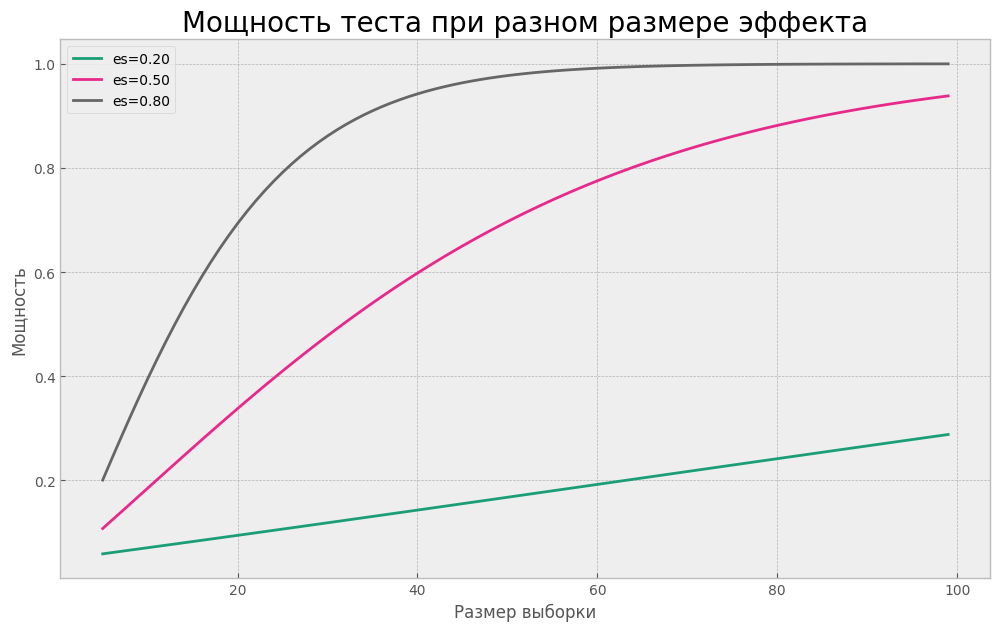

In [280]:
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5,100))

analysis = TTestIndPower()

_, axes = plt.subplots(1,1, figsize=(12,7))

analysis.plot_power(dep_var = 'nobs',
                    nobs = sample_sizes,
                    effect_size =effect_sizes,
                    ax=axes)

axes.set_title("Мощность теста при разном размере эффекта", fontsize=20)
axes.set_xlabel("Размер выборки")
axes.set_ylabel("Мощность")
plt.legend()